### Цели и задачи проекта

В ходе проекта, мы будем анализировать маркетинговую кампанию развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Нам необходимо разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
лог сервера с данными об их посещениях,
выгрузка их покупок за этот период,
рекламные расходы.
В процессе работы мы изучим:
откуда приходят пользователи и какими устройствами они пользуются,
сколько стоит привлечение пользователей из различных рекламных каналов;
сколько денег приносит каждый клиент,
когда расходы на привлечение клиента окупаются,
какие факторы мешают привлечению клиентов.

### Загрузим данные и подготовим их к анализу

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучим  данные и выполним предобработку. 

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

Взглянем на состав таблиц и тип данных в них

In [2]:
print(visits.head())
print(orders.head())
print(costs.head())

        User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40  
        User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99
           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-

In [3]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

Некоторые столбцы названы не змеиным шрифтом, приведём их всех к одному виду. 
Также, приведём данные с датами и временем к соответствующему типу

In [4]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

visits = visits.rename(columns={'user id':'user_id',
                      'session start': 'session_start',
                      'session end':'session_end' }
             )
orders = orders.rename(columns={'user id':'user_id',
                      'event dt':'event_dt'}
             )


In [5]:
visits['session_start'] = visits['session_start'].astype('datetime64')
visits['session_end'] = visits['session_end'].astype('datetime64')
orders['event_dt'] =orders['event_dt'].astype('datetime64')
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [6]:
visits.info()
orders.info()
costs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

In [7]:
print(visits.isna().sum()
     )

print(orders.isna().sum()
     )

print(costs.isna().sum())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64
user_id     0
event_dt    0
revenue     0
dtype: int64
dt         0
channel    0
costs      0
dtype: int64


In [8]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


В данных нет дубликатов и пропусков. Можем переходит к дальнейшему анализу данных.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [9]:
# get_profiles() — для создания профилей пользователей
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles



In [10]:
#get_retention() — для подсчёта Retention Rate
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time


In [11]:
#get_conversion() — для подсчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:
#get_ltv() — для подсчёта LTV
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
     
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [13]:
# filter_data() — для сглаживания данных,

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df


In [14]:
# plot_retention() — для построения графика Retention Rate,

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')


In [15]:
# plot_conversion() — для построения графика конверсии,

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()



In [16]:
# plot_ltv_roi — для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


### Исследовательский анализ данных


Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.

In [17]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head())

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [18]:
print(profiles['dt'].min())
print(profiles['dt'].max())

2019-05-01
2019-10-27


In [19]:
observation_date = profiles['dt'].max()
horizon_days = 7

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Посмотрим на таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [20]:
profiles_by_country = (
        profiles.groupby(['region'])
        .agg({'user_id': 'nunique',
             'payer':'sum'})
        .rename(columns={'user_id': 'unique_users'})
                .sort_values(by='unique_users', ascending=False)
    )

profiles_by_country['conv, %'] = round(profiles_by_country['payer']/profiles_by_country['unique_users']*100,2)
profiles_by_country = profiles_by_country.sort_values(by='conv, %', ascending=False)
print(profiles_by_country.head())

               unique_users  payer  conv, %
region                                     
United States        100002   6902     6.90
Germany               14981    616     4.11
UK                    17575    700     3.98
France                17450    663     3.80


Из таблицы видим, что в США наибольшее количество пользователей и самый высокий процент платящих пользователей.
Теперь посмотрим на на соотношение, относительно разных устройств.

In [21]:
profiles_by_device = (
        profiles.groupby(['device'])
        .agg({'user_id': 'nunique',
             'payer':'sum'})
        .rename(columns={'user_id': 'unique_users'})
                .sort_values(by='unique_users', ascending=False)
    )

profiles_by_device['conv, %'] = round(profiles_by_device['payer']/profiles_by_device['unique_users']*100,2)
profiles_by_device = profiles_by_device.sort_values(by='conv, %', ascending=False)
print(profiles_by_device.head())

         unique_users  payer  conv, %
device                               
Mac             30042   1912     6.36
iPhone          54479   3382     6.21
Android         35032   2050     5.85
PC              30455   1537     5.05


Разница по устройствам не такая большая, как по странам, тем не менее, пользователи на Mac и iPhone чаще становятся платящими, чем на Andriod и PC.
Теперь посмотрим на конверсию в разбивке по каналам привлечения

In [22]:
profiles_by_channel= (
        profiles.groupby(['channel'])
        .agg({'user_id': 'nunique',
             'payer':'sum'})
        .rename(columns={'user_id': 'unique_users'})
                .sort_values(by='unique_users', ascending=False)
    )

profiles_by_channel['conv, %'] = round(profiles_by_channel['payer']/profiles_by_channel['unique_users']*100,2)
profiles_by_channel = profiles_by_channel.sort_values(by='conv, %', ascending=False)


In [23]:
print(profiles_by_channel)

                    unique_users  payer  conv, %
channel                                         
FaceBoom                   29144   3557    12.20
AdNonSense                  3880    440    11.34
lambdaMediaAds              2149    225    10.47
TipTop                     19561   1878     9.60
RocketSuperAds              4448    352     7.91
WahooNetBanner              8553    453     5.30
YRabbit                     4312    165     3.83
MediaTornado                4364    156     3.57
LeapBob                     8553    262     3.06
OppleCreativeMedia          8605    233     2.71
organic                    56439   1160     2.06


Самые успешные каналы по показателям конверсии - FaceBoom, AdNonSense, lambdaMediaAds и TipTop. Остальные каналы сильно отстают в конверсии. 


### Маркетинг

В этой части оценим, как распределялись расходы на рекламу. Для этого мы сначала посчитаем общие затраты, затем посмотрим, как они распределены по каналам и сколько пользователей принес каждый источник. 

Посчитаем общую сумму расходов на маркетинг.


In [24]:
print(costs['costs'].sum())


105497.30000000002


Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.


In [25]:
costs_per_channel = (
    costs.groupby('channel')
    .agg({'costs': 'sum'})
    .rename(columns={'cost': 'costs_per_channel'})
)

costs_per_channel.sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Из таблицы выше видим, что затраты на рекламу в TipTop превышают половину всех затрат на рекламу и являются абсолютным лидером по этому показателю. На втором месте идет FaceBoom и составляют более 30% общих затрат. 

Теперь посмотрим, какие каналы принесли приложению больше пользователей.

In [26]:
users_per_channel = (
    profiles.groupby('channel')
    .agg({'user_id': 'count'})
    )

users_per_channel.sort_values(by='user_id', ascending=False)

,user_id
channel,
organic,56439
FaceBoom,29144
TipTop,19561
OppleCreativeMedia,8605
LeapBob,8553
WahooNetBanner,8553
RocketSuperAds,4448
MediaTornado,4364
YRabbit,4312


Мы видим, что больше всего пользователей пришли напрямую, это почти столько же, сколько из FaceBoom и TipTop вместе взятых. Однако, это не говорит о их прибыльности, поэтому выводы делать пока рано.
Теперь посмотрим, как менялись затраты на рекламу с течением времени, для этого построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. 

In [27]:
costs['week'] = (
    pd.to_datetime(costs['dt']).dt.isocalendar().week
)
costs['month'] = pd.to_datetime(costs['dt']).dt.month


In [28]:
costs_week_history = costs.pivot_table(index=['week'], columns='channel', values='costs', aggfunc='sum')


In [29]:
costs_month_history = costs.pivot_table(index=['month'], columns='channel', values='costs', aggfunc='sum')


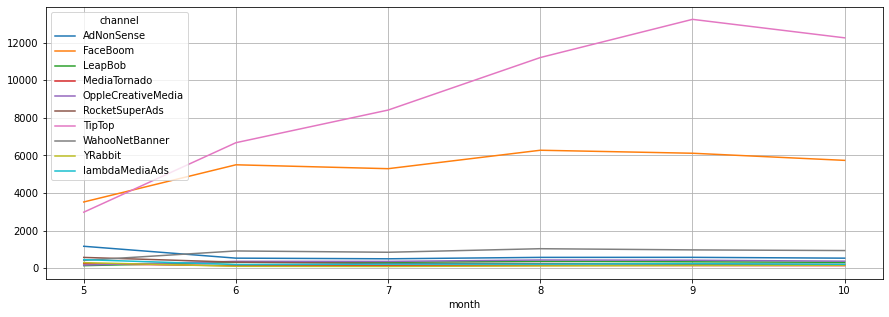

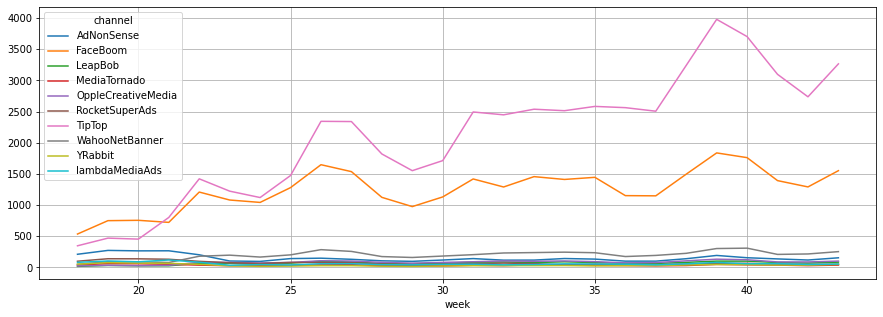

In [30]:
costs_month_history.plot(grid=True, figsize=(15,5));
costs_week_history.plot(grid=True, figsize=(15,5));

Единственные два канала, с растущими затратами на привлечение - это те же FaceBoom и TipTop, однако рост FaceBoom гораздо умеренее, чем TipTop. При рассмотрении по месяцам он почти незаметен со второго месяца, однако на втором графике видно, что в  данном периоде был как рост, так и спад. 
Затраты на рекламу в остальных канала практически не изменились.
Для дальнейшего анализа, нам надо понимать, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

In [31]:
cac_per_channel = profiles.pivot_table(
    index='channel', values='acquisition_cost', aggfunc='mean'
)
cac_per_channel.sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


In [32]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [33]:
print(profiles.query('channel not in ["organic"]')['acquisition_cost'].mean().round(2))

1.13


Как и ожидалось, самыми дорогими оказались пользователи из TipTop (2.79) и более, чем в два раза превышают среднюю стоимость привлечения (1.13), как и стоимость пользователей из FaceBoom (1.11), на третьем месте AdNonSense (1.01) и их стоимость незначительно отличается от предыдущих.
Однако, LeapBob и OppleCreativeMedia - каналы, которые принесли достаточно большое количество пользователей (8553 и 8605 пользователей соответственно) Возможно, есть смысл вложить больше средств в рекламу у них, но это будет понятно после анализа окупаемости рекламы.

### Оцените окупаемость рекламы

Перейдем к анализу окупаемости рекламы. Для этго оценим LTV, ROI и CAC как для всех пользователей, так и в разбивке по тем же группам - странам, устройствам и каналам привлечения.
Необходимо учесть, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 


Начнем с того, что проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

При анализе окупаемости расходов целесообразно не включать органических пользователей. Удалим данные с этими пользователями

In [34]:
profiles = profiles.query('channel not in ["organic"]')
costs = costs.query('channel not in ["organic"]')


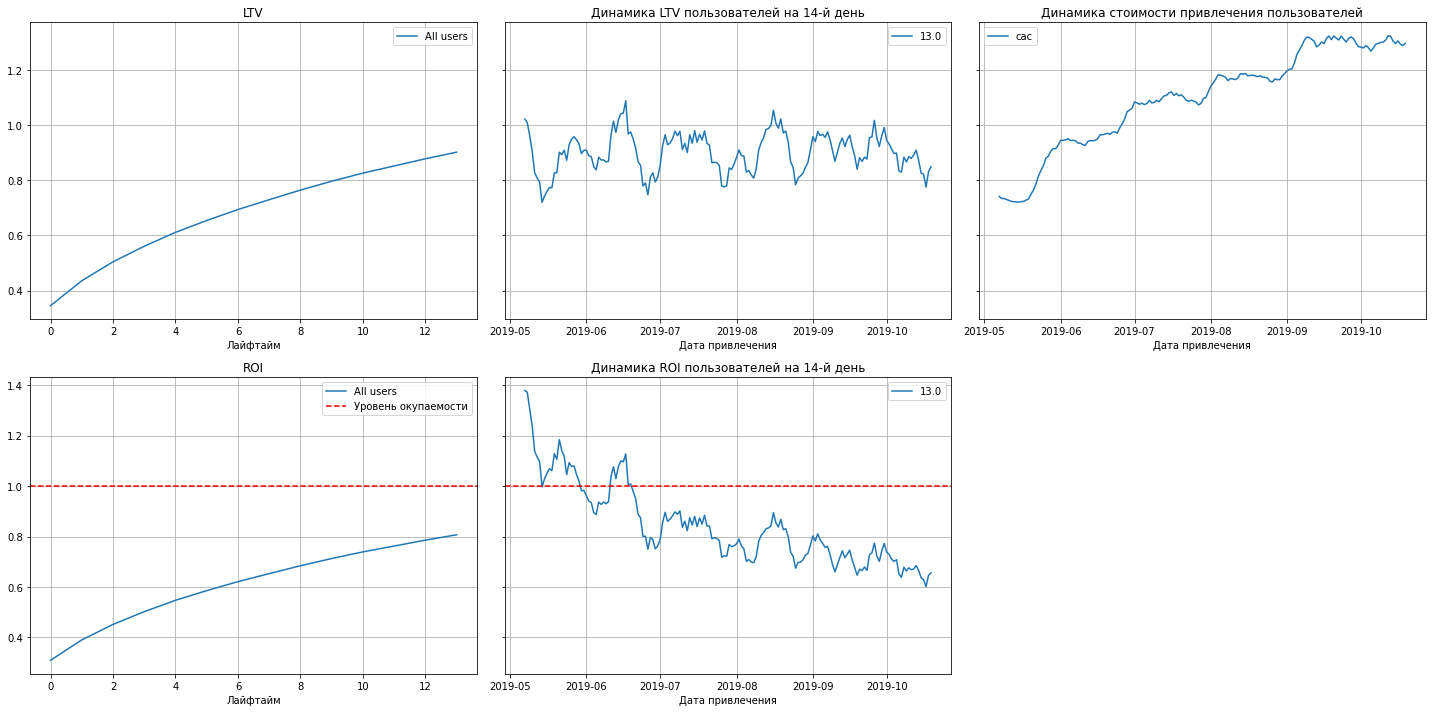

In [35]:
observation_date = datetime(2019,11,1).date() 

horizon_days = 14


dimensions = []

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы: стоимость привлечения растет, при том, что LTV колеблется, но не растет значительно, соотвественно и ROI со временем снижается. И как результат реклама не окупается, в итоге на 14-ый день ROI чуть выше 0.8.
В первые два месяца ROI выше уровня окупаемости, и при этом стабильно снижается. 

Теперь посмотрим как обстоят дела в разных странах.

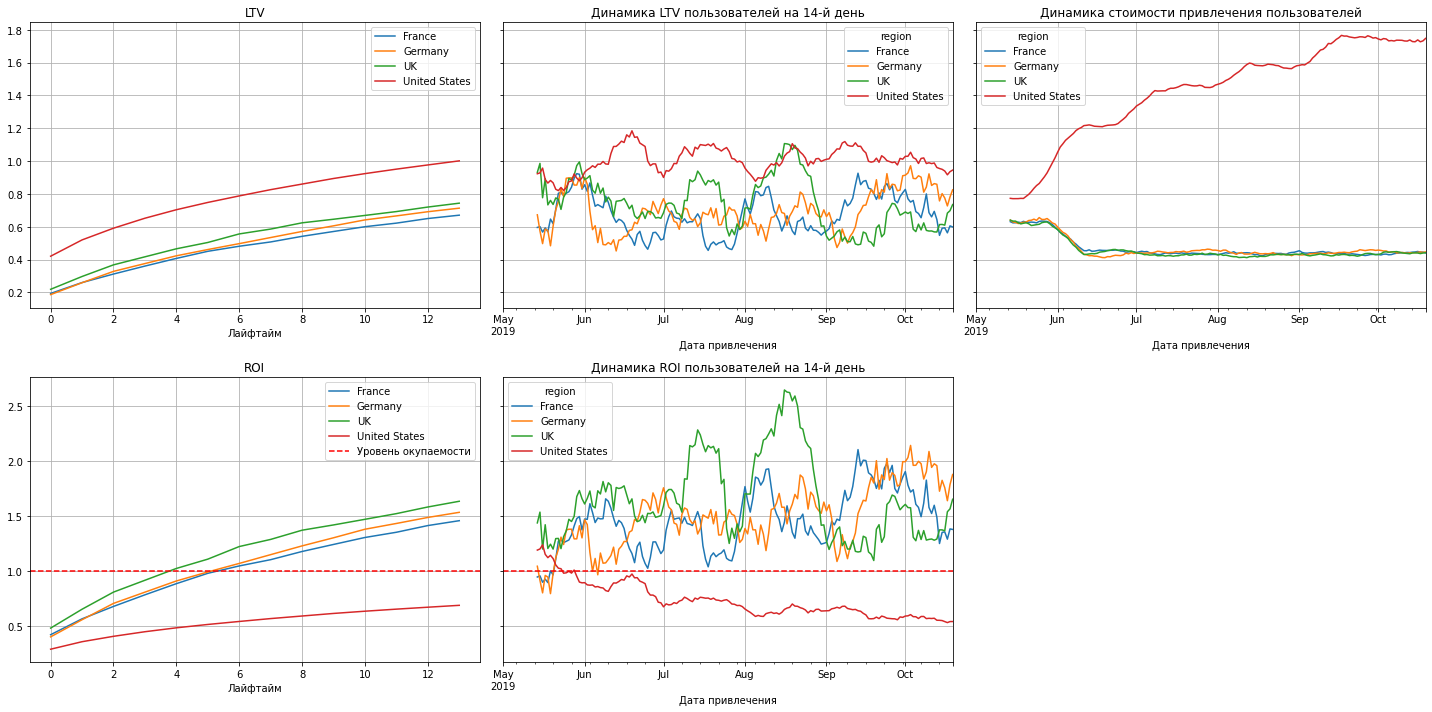

In [36]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

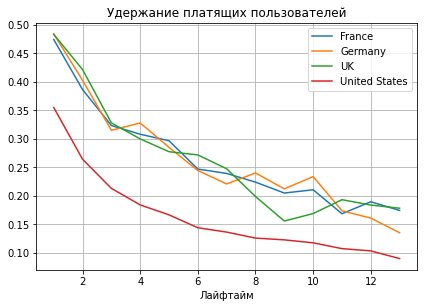

In [37]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

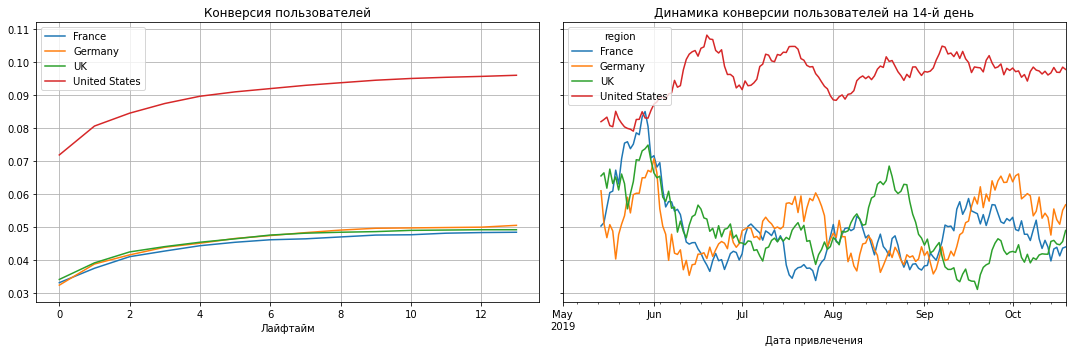

In [38]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions,
    ignore_horizon=False,
)

plot_conversion(conversion, conversion_history, horizon_days, window=14)


Мы видим, что в трех странах реклама окупается, ROI в конце второй недели в Германии и Великобритании и во Франции находится около отметки 1,5 и  окупается уже в течение первой недели, а вот в США реклама не окупается вообще, показатель ниже 0,7. 
К тому же, ROI стабильно падает за счет роста инвестиций при достаточно стабильном LTV. К концу изучаемого периода стоимость привлечения клиентов в США превышает стоимость в других странах почти в пять раз, при том, что LTV не сильно выше.
К тому же удержание пользователей в США в два раза ниже, чем в других странах. 
При этом, конверсия пользователей из США почти в два раза превышает все остальные страны, в то время, как у европейских стран она находится на уровне 5%б у США этот показатель на конец второй недели почти достигает 10%.
Теперь проанализируем окупаемость рекламы с разбивкой по устройствам.

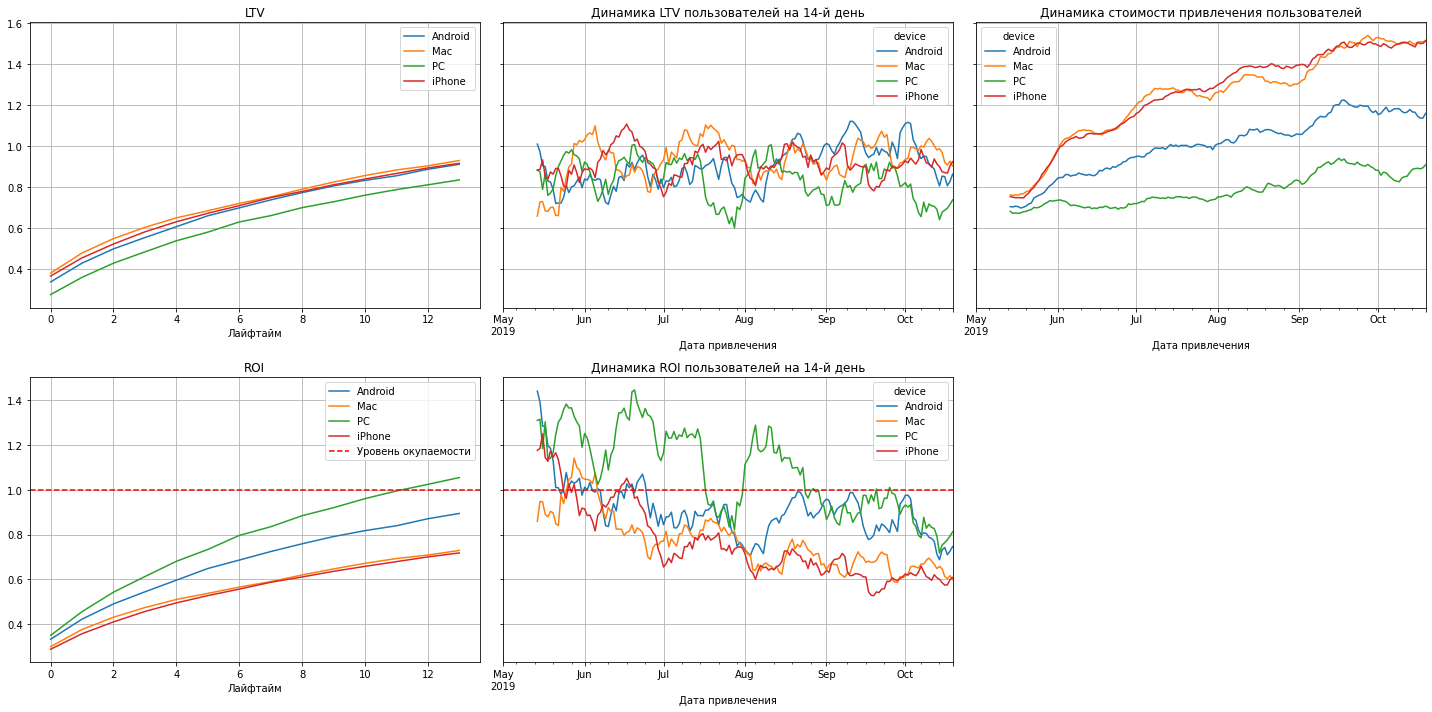

In [39]:
# смотрим окупаемость с разбивкой по устройствам
dimensions = ['device']

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)


    LTV для пользователей различных устройств отличается незначительно, хоть РС немного отстает от остальных. При этом, реклама окупается только на РС, ниже всего окупаемость на Mac и iPhone за счет увеличения бюджета на рекламу. 
    Опять же, затраты на привлечение пользователей растут, а LTV растет незначительно.
    Но и у РС окупаемость падает к сентябрю.

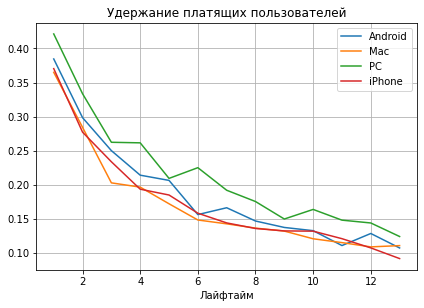

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

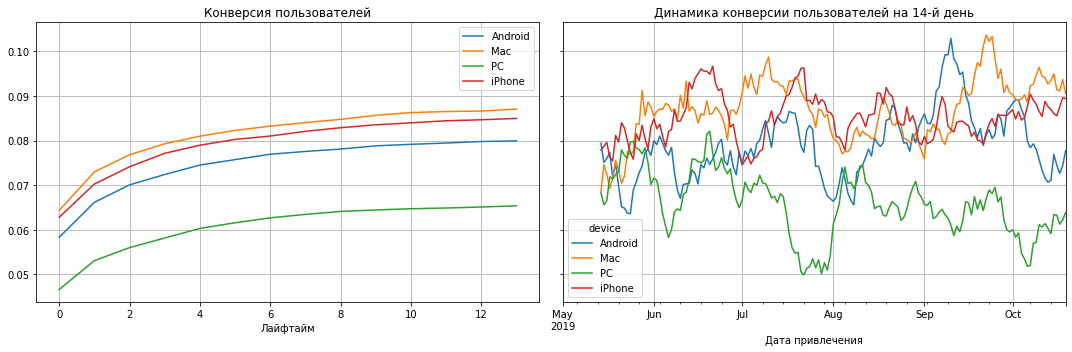

In [41]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions,
    ignore_horizon=False,
)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

Удержание пользователей ниже всего на iPhone, хоть и сложно назвать это выдающейся разницей. А вот РС уверено обходит все остальные устройства и занимает первое место на протяжение всего лайфтайма.
Конверсия на РС значительно ниже других устройств.
Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. 

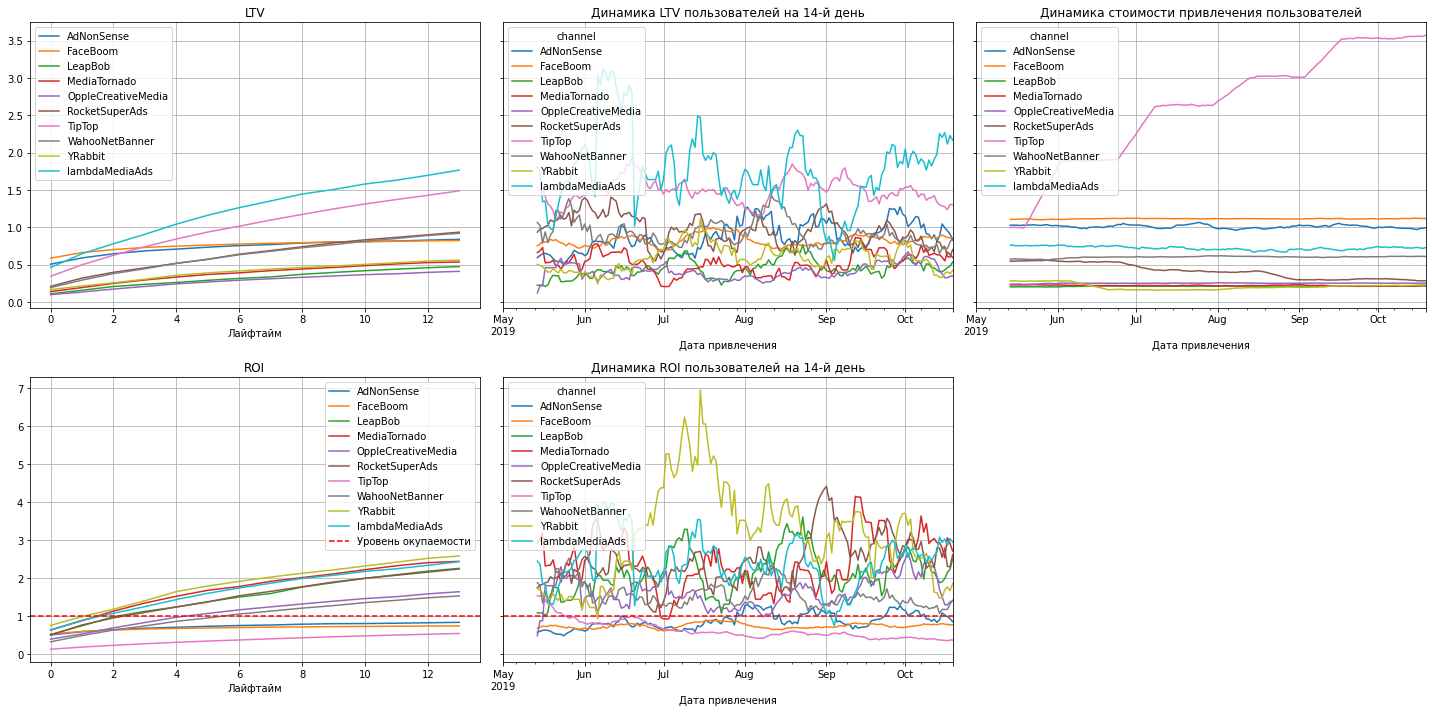

In [42]:
# смотрим окупаемость с разбивкой по устройствам
dimensions = ['channel']


# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)


# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Мы видим большую разницу окупаемости между TipTop и YRabbit, где первое находится около 0,5, а второе близится к 3. Итого, реклама не окупается на каналах TipTop, FaceBoom и AdNonSense. Несмотря на то, что эти каналы принесли наибольшее количество пользователей, их качество гораздо ниже тех, кто пришел с YRabbit, MediaTornado lambdaMediaAds и RocketSuperAds. 
TipTop получил больше всего средств на рекламу и оказался наименее окупаемым каналом.

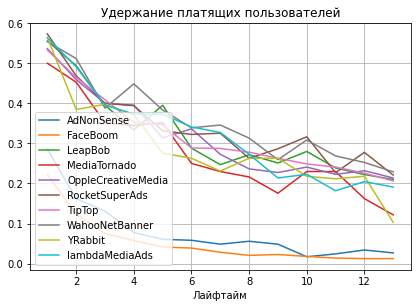

In [43]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

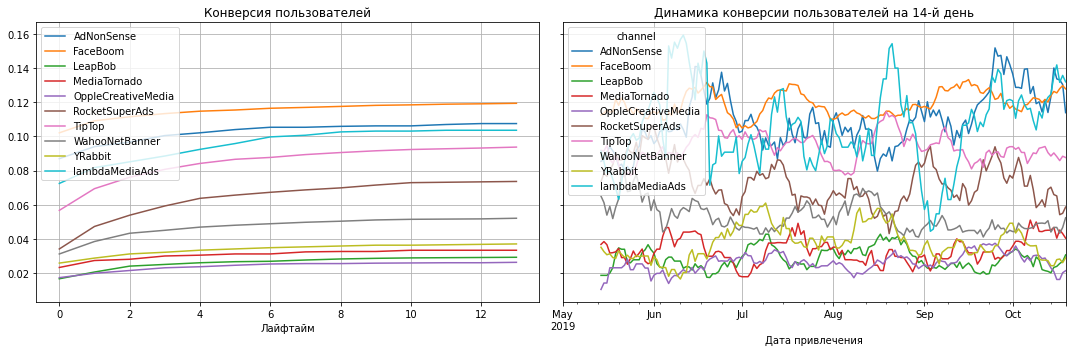

In [44]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions,
    ignore_horizon=False,
)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

Удержание пользователей FaceBoom и AdNonSense также низко, как и у YRabbit и MediaTornado, но все же у двух последних находится на отметке 0,1, а у первых пересекает эту черту до 4-го дня лайфтайма. 
Конвесрия же у тех же каналов - FaceBoom и AdNonSense находится на самом высоком уровне, видимо, пользователи быстро теряют интерес к приложению.

В результате анализа маркетинговой кампании мы можем сделать следующие выводы:

   - Реклама не окупается в целом, на 14-ый день ROI чуть выше 0.8.Стоимость привлечения растет, при том, что LTV колеблется, но не растет значительно, соотвественно и ROI со временем снижается. 
   - В первые два месяца ROI выше уровня окупаемости, и при этом стабильно снижается. 
   - ROI в конце второй недели в Германии и Великобритании — около 2, во Франции ближе к 1,7 и тоже окупается, а вот в США реклама не окупается вообще, показатель ниже 0,8.
   - LTV для пользователей различных устройств отличается незначительно, хоть РС немного отстает от остальных. При этом, реклама не окупается на Mac и iPhone за счет увеличения бюджета на рекламу. 
   - Мы видим большую разницу окупаемости между TipTop и YRabbit, где первое находится около 0,5, а второе близится к 3. Итого, реклама не окупается на каналах TipTop, FaceBoom и AdNonSense.
   - Вероятнее всего низкая окупаемость объясняется повышением расходов на рекламу в США, которое не оправдало ожидания. К тому же вопреки тому, что FaceBoom и AdNonSense приносят много клиентов, очень мало из них остаются в приложении дольше четырех дней.

###  Выводы по проекту

   Самые успешные каналы по показателям конверсии - FaceBoom, AdNonSense, lambdaMediaAds и TipTop. Остальные каналы сильно отстают в конверсии. Также, мы узнали, что в США наибольшее количество пользователей и самый высокий процент платящих пользователей.
   
   Как и ожидалось, самыми дорогими оказались пользователи из TipTop и более, чем в два раза превышают стоимость пользователей из FaceBoom, на третьем месте AdNonSense и их стоимость незначительно отличается от предыдущих.
    
   Однако, LeapBob и OppleCreativeMedia - каналы, которые принесли достаточно большое количество пользователей (8553 и 8605 пользователей соответственно) Возможно, есть смысл вложить больше средств в рекламу у них, но это будет понятно после анализа окупаемости рекламы.
    
   Мы видим, что в трех странах реклама окупается, ROI в конце второй недели в Германии и Великобритании и во Франции находится около отметки 1,5 и  окупается уже в течение первой недели, а вот в США реклама не окупается вообще, показатель ниже 0,7. 
    
   К тому же, ROI стабильно падает за счет роста инвестиций при достаточно стабильном LTV. К концу изучаемого периода стоимость привлечения клиентов в США превышает стоимость в других странах почти в пять раз, при том, что LTV не сильно выше. Также, удержание пользователей в США в два раза ниже, чем в других странах. При этом, конверсия пользователей из США почти в два раза превышает все остальные страны, в то время, как у европейских стран она находится на уровне 5%, у США этот показатель на конец второй недели почти достигает 10%.
    
   LTV для пользователей различных устройств отличается незначительно, хоть РС немного отстает от остальных. При этом, реклама не окупается на Mac и iPhone за счет увеличения бюджета на рекламу. 
   
   Мы видим большую разницу окупаемости между TipTop и YRabbit, где первое находится около 0,5, а второе близится к 3. Итого, реклама не окупается на каналах TipTop, FaceBoom и AdNonSense.
   
   Вероятнее всего низкая окупаемость объясняется повышением расходов на рекламу в США и в TipTop, которое не оправдало ожидания. К тому же вопреки тому, что FaceBoom и AdNonSense и приносит много клиентов, очень мало из них остаются в приложении дольше четырех дней. Тем не менее, история окупаемости AdNonSense показывает потенциал к росту, в отличие от FaceBoom, который в среднем остается неизменным.
    
   Основываясь на проделаной работе, могу предположить, что есть смысл снизить затраты на рекламу через TipTop в США и направить больше средств на рекламу в lambdaMediaAds и AdNonSense. Также, удержание пользователей из FaceBoom и AdNonSense ниже всех остальных, возможно, есть смысл найти в чем причина.